# Simulation par des chaînes de Markov

## Partie théorique

### Théorie physique

Modus operandi : On balance $100$ électrons, on regarde leur trajectoire. On réunit si la distance de Hamming est $> 90$% de la distance totale puis garde en mémoire les chemins empruntés par au moins $x$% des électrons.

Modélisation : Grille avec bruit gaussien, écart modélisé par une barrière de potentiel rectiligne égale à la moitié (la probabilité de passer est proportionnelle à la transmission). Nombre max d'itérations pour déterminer s'il est perdu.

Calcul de l'intensité : La résistance est proportionnelle à la longueur des chemins

Avantage des chemins : On place 80 % des électrons aléatoirement sur les chemins proportionnellement à leur poids relatif et les 20% restants sont rajoutés au début de la grille

Incoming : Remplacement de la barrière avec l'expression analytique des fonctions de Bessel, ajout d'intermédiaires

Résistance d'un chemin égale à sa longueur

Pour les sites interstitiels : Augmenter la taille de la grille, enlever des sites et modifier le np.clip pour que les QD puissent être dans d'autres boîtes quantiques.

Progrès à envisager :
- Tout mettre sous format de classe pour permettre une instanciation plus simple
- FAIT : Représenter les électrons sous forme de heatmaps dans les fonctions de visualisation
- Fonction de visualisation des chemins trouvés en fonction de leur coefficientage
- Accélérer l'affichage en plaçant tous les points à la fin (ne sert à rien in fine)
- Refaire l'union-find pour n'utiliser que des chemins longs

### L'implémentation dans les grandes lignes

## Initialisation de la grille

### Constantes du problème

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.cluster.hierarchy import DisjointSet

In [39]:
m_e = 9.10938356e-31 #en kg
hbar = 1.0545718e-34 #en J.s
E = 1 #en eV

In [40]:
N = 30 # Taille de la grille
a = 1e-9 # Taille de chaque maille élémentaire
sigma = 0.3 #Ecart-type du bruit gaussien
n_el_initial = 100
n_max_chemin = 150
# tableau_tension = np.linspace(0.,1.,10, dtype = np.float64) #Valeurs de la tension à appliquer
# Précision de la tension : environ 34 décimales
N_iterations = 500 # Nombre d'itérations par étape
prob_deb = 0.2 # Probabilité de rester dans le début de la grille à chaque initialisation
dropout = 0.3 # Probabilité de disparition des sites
coupe = 1 #Permet de cadrer la possibilité pour un électron de sortir de sa case, 0.5 pour rester dans sa case

### Génération du bruit et des variables

In [41]:
z = np.zeros((N,N,2)) # Deux grilles : l'une suit les abscisses, l'autre les ordonnées
x = np.random.normal(0,sigma/2,size = (N,N))
y = np.random.normal(0,sigma/2,size = (N,N))
x = np.clip(x,-coupe,coupe) #On empêche les points de sortir de leur case
y = np.clip(y,-coupe,coupe) #Idem
bruit = np.stack((x,y),axis=-1) 
z += bruit #Génère le bruit gaussien

electrons = np.full((N,N),fill_value=0) #Trace de la position des électrons à tout instant sur la grille
traces = {i : [] for i in range(n_el_initial)} #Dictionnaire des chemins des électrons à une phase donnée
chemins = {} #Dictionnaire des chemins (id) retenus avec leur poids en valeur
table_id = {} #Dictionnaire qui à chaque id associe le chemin correspondant


In [42]:
sites = np.random.choice([0, 1], size=(N, N), p=[dropout, 1 - dropout])
#print(dropout_array)

In [43]:
def reinitialise():
    """Permet de réinitialiser les paramètres entre deux modélisations"""
    global x,y,z,electrons,bruit,traces,chemins, table_id, sites
    z = np.zeros((N,N,2)) # Deux grilles : l'une suit les abscisses, l'autre les ordonnées
    x = np.random.normal(0,sigma/2,size = (N,N))
    y = np.random.normal(0,sigma/2,size = (N,N))
    x = np.clip(x,-coupe,coupe) #On empêche les points de sortir de leur case
    y = np.clip(y,-coupe,coupe) #Idem
    bruit = np.stack((x,y),axis=-1) 
    z += bruit #Génère le bruit gaussien

    electrons = np.full((N,N),fill_value=0) #Trace de la position des électrons à tout instant sur la grille
    traces = {i : [] for i in range(n_el_initial)} #Dictionnaire des chemins des électrons à une phase donnée
    chemins = {} #Dictionnaire des chemins retenus avec leur poids en valeur
    table_id = {}
    sites = np.random.choice([0, 1], size=(N, N), p=[dropout, 1 - dropout])


### Fonctions d'affichage

#### Affichage des QD

In [44]:
def affiche_grille(z,fig,ax):
    """Affiche la position des QD sur la grille
    Nécessite de préciser la figure et les axes sur lesquels on souhaite afficher pour pouvoir 
    superposer l'affichage des QD avec d'autres éventuellement ou faire des animations.
    Voir affiche_grille_lazy sinon"""
    N,_,_ = z.shape
    ax.set_xticks(np.arange(0,N,1), labels = []) #Force le quadrillage à correspondre aux cases
    ax.set_yticks(np.arange(0,N,1), labels = [])
    for i in range(N):
        for j in range(N):
            if sites[i,j] == 1:
                xc = i+0.5 + z[i,j,0]
                yc = j+0.5 + z[i,j,1]
                ax.scatter(xc,yc, color = "red")
    ax.grid()

In [45]:
def affiche_grille_lazy(z):
    N,_,_ = z.shape
    plt.xticks(np.arange(0,N,1), labels = [])
    plt.yticks(np.arange(0,N,1), labels = [])
    for i in range(N):
        for j in range(N):
            if sites[i,j]==1:
                xc = i+0.5 + z[i,j,0]
                yc = j+0.5 + z[i,j,1]
                plt.scatter(xc,yc, color = "red")
    plt.grid()

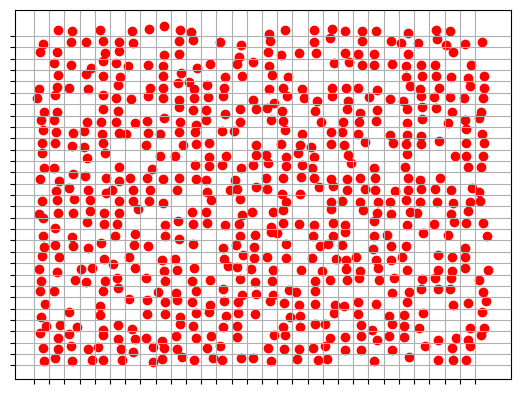

In [46]:
fig,ax = plt.subplots()
affiche_grille(z,fig,ax)

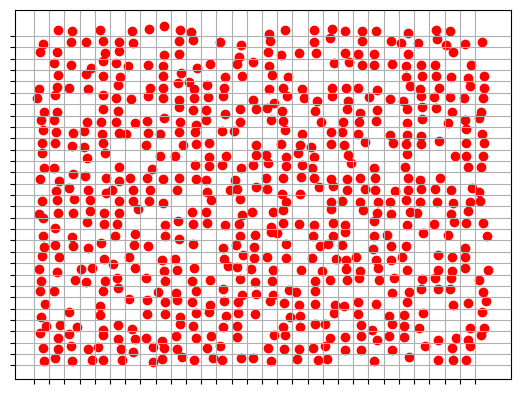

In [47]:
affiche_grille_lazy(z)

#### Affichage des électrons

In [48]:
def affiche_electrons(electrons,fig,ax):
    """Affichage des électrons sur la grille"""
    N,_ = electrons.shape
    ax.set_xticks(np.arange(0,N+1,1), labels = [])
    ax.set_yticks(np.arange(0,N+1,1), labels = [])
    for i in range(N):
        for j in range(N):
            if electrons[i,j]>=1:
                rect = patches.Rectangle((i, j), 1, 1, color='black', alpha=0.5) 
                ax.add_patch(rect)           
    ax.grid()

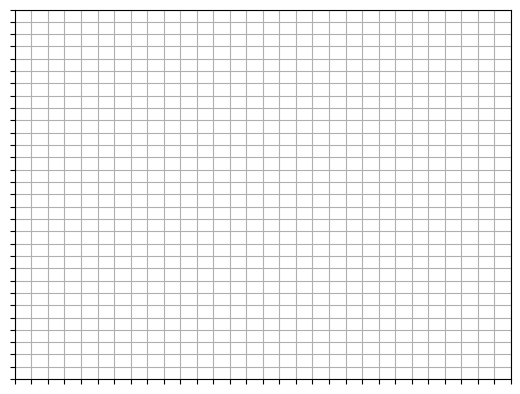

In [49]:
fig,ax = plt.subplots()
affiche_electrons(electrons,fig,ax)

In [50]:
def affiche_electrons_lazy(electrons):
    fig, ax = plt.subplots()
    N,_ = electrons.shape
    plt.xticks(np.arange(0,N+1,1), labels = [])
    plt.yticks(np.arange(0,N+1,1), labels = [])
    for i in range(N):
        for j in range(N):
            if electrons[i,j]>0:
                rect = patches.Rectangle((i, j), 1, 1, color='black', alpha=0.5) 
                ax.add_patch(rect)           
    plt.grid()

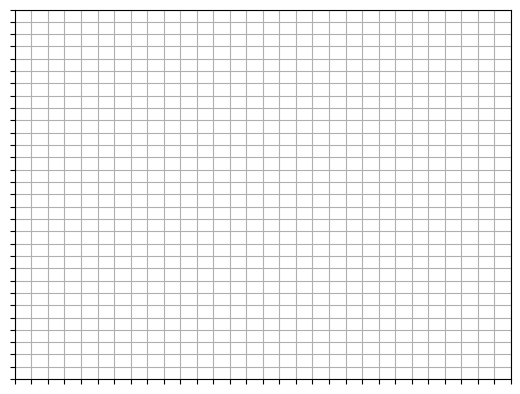

In [51]:
affiche_electrons_lazy(electrons)

In [52]:
def heatmap(electrons):
    """Affiche la carte de chaleur des électrons sur la grille"""
    plt.figure(figsize=(10, 10))
    plt.xticks(ticks=np.arange(electrons.shape[1]), labels=np.arange(electrons.shape[1]))
    plt.yticks(ticks=np.arange(electrons.shape[0]), labels=np.arange(electrons.shape[0]))

    # Tracer la heatmap
    plt.imshow(electrons, cmap=plt.cm.Blues, vmin=1)  # vmin=1 pour que les valeurs 0 soient blanches
    plt.colorbar()  # Ajouter une barre de couleur
    plt.title('Carte des électrons')
    plt.show()

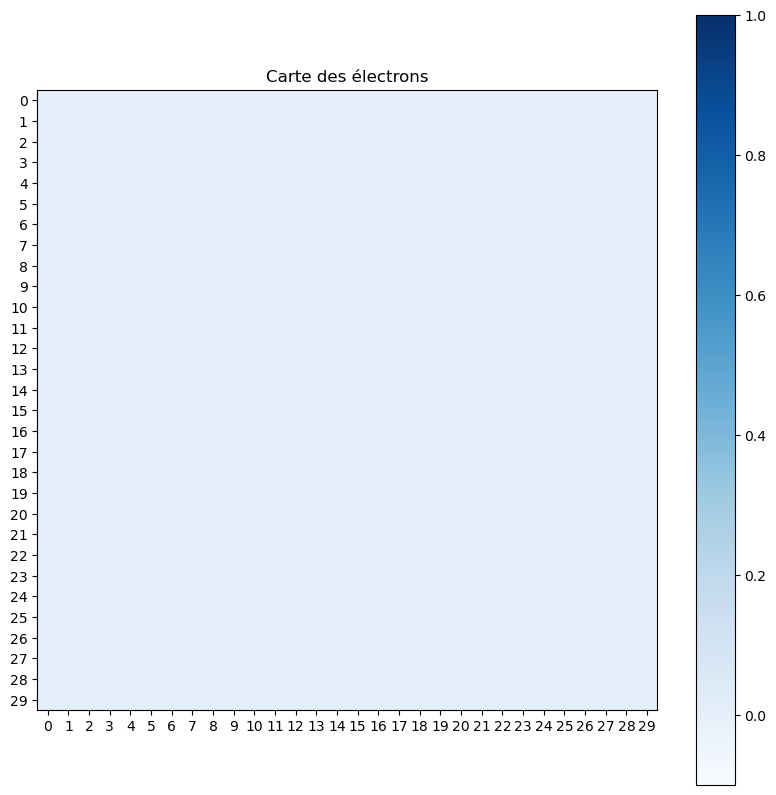

In [53]:
heatmap(electrons)

## Initialisation de la première étape

In [54]:
def first_initialisation():
    """Initialise la position des électrons lors de la première passe"""
    T = {}
    for i in range(N):
        trans = np.zeros(N,dtype=np.float32)
        for j in range(N):
            if sites[i,j]==1:
                trans[j] = 1/abs(j-i+0.1) #Formule à modifier
        if np.sum(trans)>0.:
            trans /= np.sum(trans)
        T[i] = trans
    for electron in range(n_el_initial):
        i = np.random.randint(0,N)
        pos = np.random.choice(np.arange(N), p=T[i])
        electrons[pos,0] += 1
        traces[electron] = [(pos,0)]

[1 2 3 4 4 3 6 1 5 4 4 5 2 4 8 3 2 0 6 2 5 5 1 4 5 2 1 2 4 2]


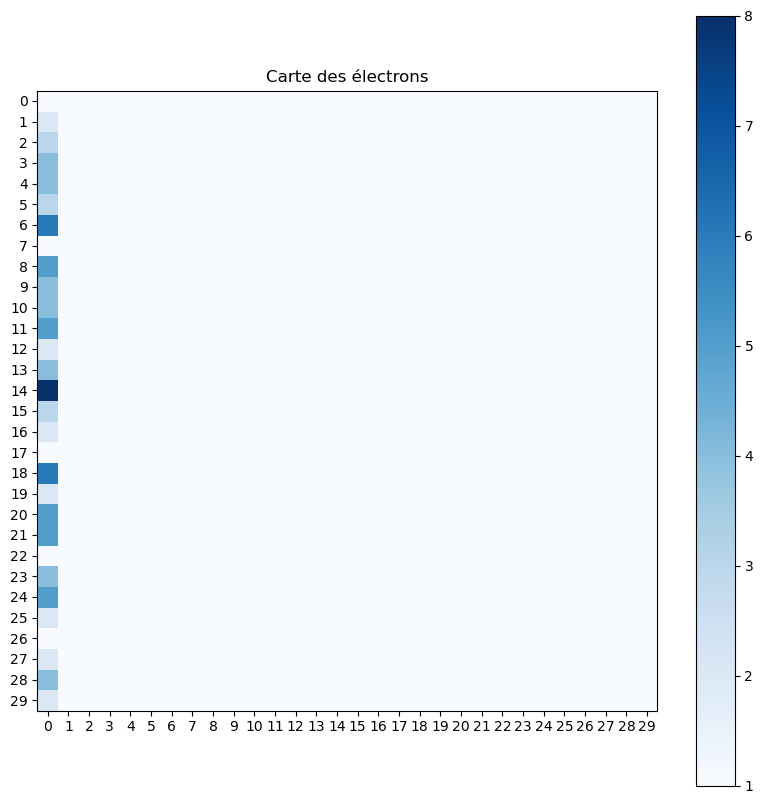

In [55]:
reinitialise()
first_initialisation()
print(electrons[:,0])
electrons[8,8]+=1
heatmap(electrons)

In [56]:
def initialise():
    """Initialise à partir du dictionnaire chemins.
    On crée un array avec les probabilités d'être sur un des chemins donnés ou placés au début puis on tire par random sampling 
    les indices allant à chacune des catégories.
    La répartition des électrons sur le chemin suit des lois exponentielles indépendantes (on pourrait aussi tester avec une loi de Poisson)"""
    global electrons, chemins, table_id, traces, sites
    probas = np.zeros(len(chemins)+1)
    li_chemins = list(table_id.keys())
    for (i,chemin) in enumerate(li_chemins):
        probas[i] = chemins[i]
    probas[len(chemins)] = prob_deb
    probas /= np.sum(probas)
    indices = np.random.choice(len(probas),n_el_initial,p=probas)
    for i in indices:
        if i == len(chemins):
            T = {}
            for i in range(N):
                trans = np.zeros(N,dtype=np.float32)
                for j in range(N):
                    if sites[i,j]==1:
                        trans[j] = 1/abs(j-i+0.1) #Formule à modifier
                if np.sum(trans)>0.:
                    trans /= np.sum(trans)
                T[i] = trans
            for electron in range(n_el_initial):
                i = np.random.randint(0,N)
                pos = np.random.choice(np.arange(N), p=T[i])
                electrons[pos,0] += 1
                traces[electron] = [(pos,0)]
        else:
            chemin = table_id[i]
            weights = np.exp(-np.arange(len(chemin)))
            weights /= np.sum(weights)
            idx = np.random.choice(len(chemin), p=weights)
            i, j = chemin[idx]
            electrons[i, j] += 1
            traces[i] = chemin[:idx+1]

## Fonctions de transition

### Calcul de toutes les probabilités

On calcule, pour toute transition admissible, la transition $$T = \frac{4 E \phi }{4E\phi + V_0^2 \sinh{\kappa \Delta}}$$ avec $\kappa = \sqrt{\frac{2m_e \phi}{\hbar^2}}$.

Par décroissance linéaire, à l'abscisse $i$, $V_i = (1-\frac{i}{N})V_0$ et donc la valeur moyenne sur une transition entre $i$ et $i+1$ est $2 V^* = \frac{2N-2i-1}{N}V_0$

In [57]:
def position_into_reality(i,j):
    return a*(i+z[i,j,0]),a*(j+z[i,j,1])

In [58]:
def distance(i,j,k,l):
    xi,yi = position_into_reality(i,j)
    xj,yj = position_into_reality(k,l)
    return np.sqrt((xi-xj)**2 + (yi-yj)**2)

In [59]:
distance(1,2,1,3)

np.float64(9.066715719912962e-10)

In [60]:
def calcul_probas(V,i,j):
    droite,gauche,haut,bas = 0.,0.,0.,0.
    phi = 2*1.60217662e-19
    if j<N-1:
        if j+1<N and sites[i,j+1] == 1:
            haut = 3
        if j>0 and sites[i,j-1] == 1:
            bas = 1
        if i+1<N and sites[i+1,j] == 1:
            droite = 1.5
        if i>0 and sites[i-1,j] == 1:
            gauche = 1.5
        sum = droite + gauche + haut + bas
        if sum==0:
            return 0.,0.,0.,0.
        else:
            return droite/sum,gauche/sum,haut/sum,bas/sum
    else:
        return 0.,0.,0.,0.    

In [61]:
calcul_probas(30,8,8)

(0.0, 0.2727272727272727, 0.5454545454545454, 0.18181818181818182)

In [62]:
def calcule_all_probas(V):
    probas = {}
    for i in range(N):
        for j in range(N):
            probas[i,j] = calcul_probas(V,i,j)
    return probas

In [63]:
print_test = calcule_all_probas(40.)
for i in range(N):
    for j in range(N):
        if sites[i,j] == 1:
            print(f"Case {i,j} :")
            print(f"Droite : {print_test[i,j][0]}")
            print(f"Gauche : {print_test[i,j][1]}")
            print(f"Haut : {print_test[i,j][2]}")
            print(f"Bas : {print_test[i,j][3]}")

Case (0, 1) :
Droite : 0.0
Gauche : 0.0
Haut : 1.0
Bas : 0.0
Case (0, 2) :
Droite : 0.0
Gauche : 0.0
Haut : 0.75
Bas : 0.25
Case (0, 3) :
Droite : 0.2727272727272727
Gauche : 0.0
Haut : 0.5454545454545454
Bas : 0.18181818181818182
Case (0, 4) :
Droite : 0.0
Gauche : 0.0
Haut : 0.75
Bas : 0.25
Case (0, 5) :
Droite : 0.2727272727272727
Gauche : 0.0
Haut : 0.5454545454545454
Bas : 0.18181818181818182
Case (0, 6) :
Droite : 0.2727272727272727
Gauche : 0.0
Haut : 0.5454545454545454
Bas : 0.18181818181818182
Case (0, 7) :
Droite : 0.0
Gauche : 0.0
Haut : 0.0
Bas : 1.0
Case (0, 10) :
Droite : 0.3333333333333333
Gauche : 0.0
Haut : 0.6666666666666666
Bas : 0.0
Case (0, 11) :
Droite : 0.6
Gauche : 0.0
Haut : 0.0
Bas : 0.4
Case (0, 13) :
Droite : 1.0
Gauche : 0.0
Haut : 0.0
Bas : 0.0
Case (0, 16) :
Droite : 0.0
Gauche : 0.0
Haut : 1.0
Bas : 0.0
Case (0, 17) :
Droite : 0.2727272727272727
Gauche : 0.0
Haut : 0.5454545454545454
Bas : 0.18181818181818182
Case (0, 18) :
Droite : 0.6
Gauche : 0.0
Haut

### Une transition markovienne

In [64]:
def deplace(V,k,probas):
    global traces, electrons, sites
    i,j = traces[k][-1]
    if j < N-1:
        probas = probas[i,j]
        if sum(probas)>0:
            directions = np.random.choice(["droite","gauche","haut","bas"],p=probas)
            if directions == "droite":
                new_i,new_j = i+1,j
            elif directions == "gauche":
                new_i,new_j = i-1,j
            elif directions == "haut":
                new_i,new_j = i,j+1
            else:
                new_i,new_j = i,j-1
            electrons[i,j] -= 1
            electrons[new_i,new_j] += 1
            traces[k].append((new_i,new_j))

In [65]:
def transition(V):
    probas = calcule_all_probas(V)
    for k in range(n_el_initial):
        deplace(V,k,probas)

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 5 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [7 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

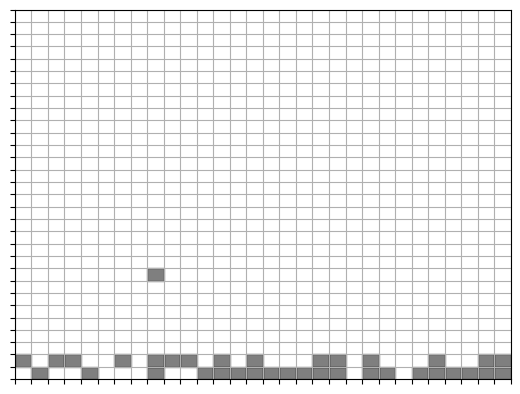

In [66]:
#reinitialise()
#first_initialisation()
transition(4.)
print(electrons)
affiche_electrons_lazy(electrons)

## Réalisation d'une étape complète

In [67]:
def levenshtein_distance(chem1,chem2):
    """Calcule la distance de Levenshtein, sera remplacée par des métriques plus adéquates"""
    l1 = len(chem1)
    l2 = len(chem2)
    set1 = set(chem1)
    set2 = set(chem2)
    inter = set1&set2
    union = set1 | set2
    return len(inter)/len(union)

In [68]:
def dist_matrix(dico,N=N):
    """Calcule des matrices de distance"""
    mat = np.zeros((N,N),dtype = np.float64)
    for i in range(N):
        for j in range(i):
            d = levenshtein_distance(dico[i],dico[j])
            mat[i,j] = d
            mat[j,i] = d
    return mat

def calcule_poids(ensemble, dico):
    jmin = min(ensemble, key = lambda i : len(dico[i]))
    return dico[jmin], len(dico[jmin])  

In [69]:
levenshtein_distance([1,2,3],[3,4,5])

0.2

In [70]:
def reunion_chemins(dico,threshold=0.5,N=N):
    dist_mat = dist_matrix(dico,N=N)
    disjoint_set = DisjointSet(range(N))
    edges = [(i,j) for i in range(N) for j in range(N)]
    edges.sort(key = lambda x : dist_mat[x[0],x[1]], reverse=True)
    for edge in edges:
        if dist_mat[edge[0],edge[1]]<=threshold:
            return disjoint_set.subsets()
        _ = disjoint_set.merge(edge[0],edge[1])
    return disjoint_set.subsets()

In [71]:
dico = {0:[1,2,3],1:[3,4,5],2:[1,2,6]}
print(dist_matrix(dico,N=3))
reunion_chemins(dico,N=3)

[[0.  0.2 0.5]
 [0.2 0.  0. ]
 [0.5 0.  0. ]]


[{0}, {1}, {2}]

In [72]:
def etape(V,first = False):
    global chemins
    if first:
        first_initialisation()
    else:
        initialise()
    for _ in range(N_iterations):
        transition(V)
    chemins.clear()
    table_id.clear()
    subsets = reunion_chemins(traces)
    k=0
    for ensemble in subsets:
        repr,poids = calcule_poids(ensemble, traces)
        table_id[k] = repr
        chemins[k] = poids
        k+=1

## Modélisation de l'ensemble

In [73]:
def simulation(array_V):
    reinitialise()
    for (i,v) in enumerate(array_V):
        etape(v, first = (i==0))
        heatmap(electrons)

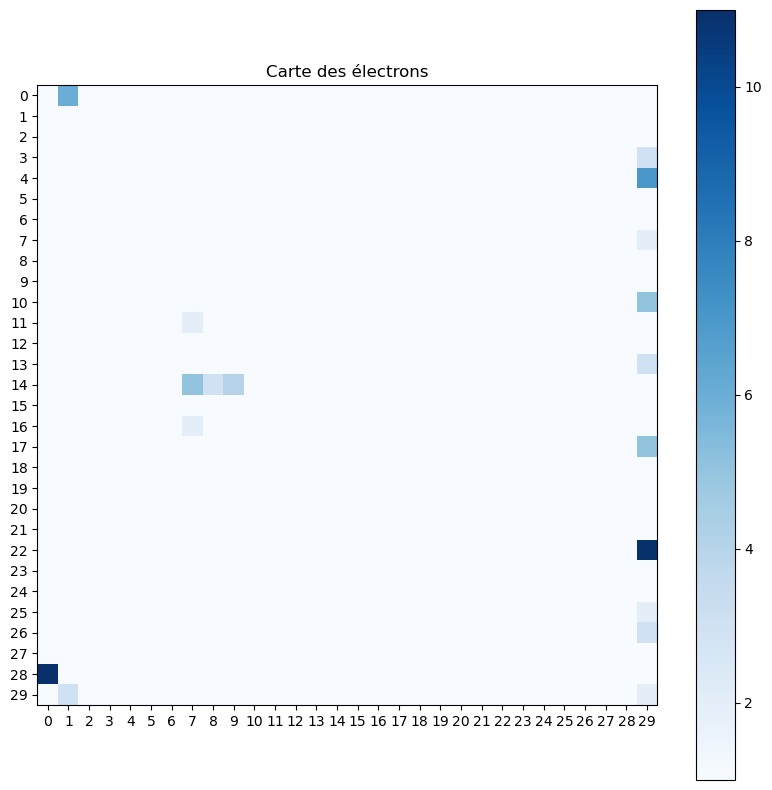

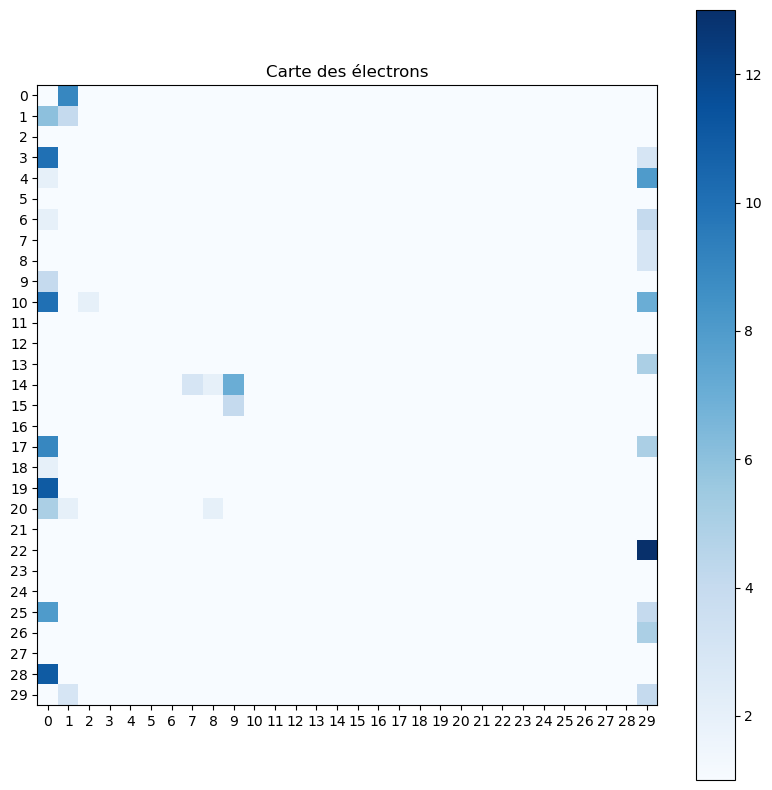

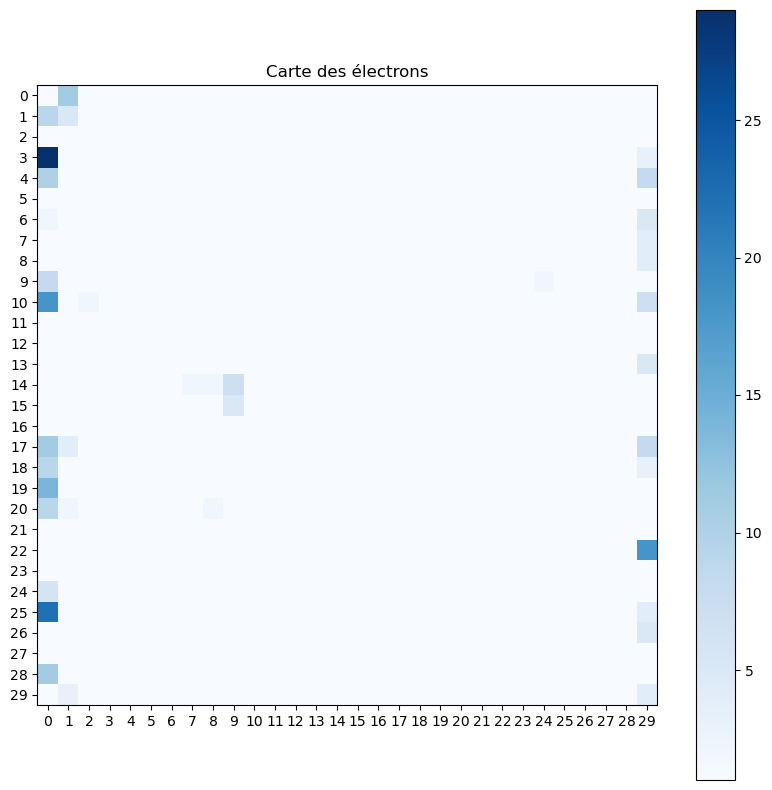

In [74]:
array_V = [10,11,12]
simulation(array_V)